In [92]:
import math 

import numpy as np
import torch
from scipy.optimize import minimize

import pyro
import pyro.contrib.gp as gp
torch.set_default_tensor_type(torch.DoubleTensor)

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif' # Setting font for plots


#### Variables

In [93]:
######################### CHOOSE NOISE VARIANCE AND OFFSET VALUES FOR INITIAL SAMPLES ###########################
ini_noise = 0                           # <--
ini_offset = 0                          # <--

######################### CHOOSE NUMBER OF INITIAL X SAMPLES AND RANDOM SEED ####################################
num_ini_samples = 5                     # <--
seed = 1                                # <--

######################### CHOOSE RESULUTION OF X FOR EVALUATION OF SURROGATE GPR AND PLOTTING ###################
X_res = torch.linspace(-1.5, 1.5, 200)  # <--

######################### CHOOSE VARIANCE AND LENGTHSCALE FOR KERNEL ############################################
var_kernel = torch.tensor(10)           # <--
length_kernel = torch.tensor(0.5)       # <--

######################### CHOOSE NOISE FOR GPR MODEL ############################################################
gpr_noise = torch.tensor(0.1)           # <--

######################### CHOOSE THRESHOLD FOR CHOOSING MACHINE 1 OR 2 ##########################################
threshold = 1.5                         # <--


#### Definition of Objective Function and two 'machine' functions for sampling

In [94]:
def objective(x, noise=0.0, offset = 0.0):
    #noise = np.random.normal(0, noise) + offset
    return ((x - 0.5)*x**3 + torch.sin(6*x) ) #+ noise

def machine_1(x, noise=0.0, offset = 0.0): 
    #noise = np.random.normal(0, noise) + offset
    return ((x - 0.4)*x**3 + torch.sin(6.5*x) ) #+ noise

def machine_2(x, noise=0.0, offset = 0.0): 
    #noise = np.random.normal(0, noise) + offset
    return ((x - 0.3)*x**3 + torch.sin(7*x) +0.3) #+ noise 

#### Initial sampling

In [95]:
# Initial sampling of the domain
np.random.seed(seed)
X_init,_ = torch.sort(torch.tensor(np.random.uniform(-1.5, 1.5, num_ini_samples))) 

# Sample the domain with your choice of machine
y = torch.tensor([machine_2(x, noise=ini_noise, offset=ini_offset) for x in X_init])

#### Plotting the initial samples and the objective function

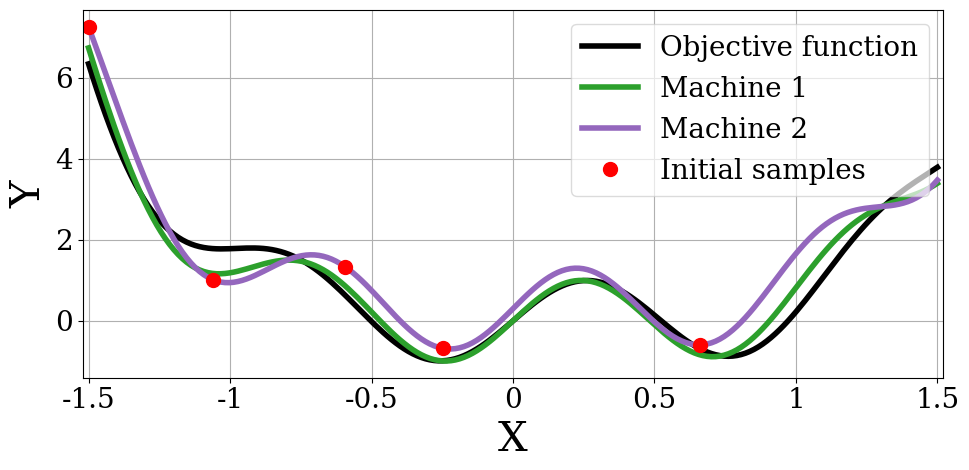

In [96]:
plt.figure(figsize=(10, 5))
linewidth = 4

plt.plot(X_res, objective(X_res, noise=0, offset=0), color="k", lw=linewidth, label='Objective function') # Plot the objective function without noise or offset
plt.plot(X_res, machine_1(X_res, noise=0, offset=0), color="C2",lw=linewidth, label='Machine 1') # Plot the first machine function without noise or offset
plt.plot(X_res, machine_2(X_res, noise=0, offset=0), color="C4", lw=linewidth, label='Machine 2') # Plot the second machine function without noise or offset
plt.plot(X_init, y, 'ro', markersize=10, label='Initial samples') # Plot the initial samples

# If you wish you can plot initial samples from both machines, but you will have to run the code twice with different machines
#M1_iniSamples = y
#M2_iniSamples = y
#plt.plot(X_init, M1_iniSamples, 'ro', markersize=10, label='Initial samples from machine 1') # Plot the initial samples for machine 1
#plt.plot(X_init, M2_iniSamples, 'o', markersize=10, label='Initial samples from machine 2') # Plot the initial samples for machine 2

fontsize = 20
plt.xlim([-1.52, 1.52])
plt.yticks([0,2, 4, 6],[0,2, 4, 6], fontsize=fontsize ) 
plt.xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], fontsize=fontsize )

plt.legend(loc=1, prop = {'size':20}, framealpha=0.7)
  
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)
plt.tight_layout(rect=[0.02, 0.04, 1, 1])
#plt.savefig('functions_&_ini_samples.pdf', format='pdf')

#### Definition of the Kernel

In [97]:
# Clearing parameters
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1,variance=var_kernel, lengthscale=length_kernel
    )

#### Definition of Surrogate Function - GPR

In [98]:
gpr = gp.models.GPRegression(X_init, y, kernel=kernel, noise=gpr_noise)

# Define optimizer and loss function
optim = torch.optim.Adam(gpr.parameters(), lr=0.005) 
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss 
losses = []

#### Acqusition Function

In [99]:
def lower_confidence_bound(x, kappa, gpr):
    mu, variance = gpr(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

#### Optimization of the acquisition function

In [100]:
# Optimizing the acquisition function - Function that returns the next x to sample
def opt_acquisition(x, kappa, gpr):
    min_val, min_index = lower_confidence_bound(x, kappa, gpr).min(dim=0)
    next_x = x[min_index]
    
    # Find distance between min_val and predicted mean to determine which machine to use for the sample
    mu,_ = gpr(x, full_cov=False, noiseless=False)
    distance = math.dist((min_val,),(mu[min_index],))
    print(f"distance: {distance}")
    return next_x, min_val, min_index, distance

#### Updating the GPR Model with Every New Data Point

In [101]:
# Updating the gpr model for each new data point
def new_posterior(new_x, gpr, distance):
    new_x = new_x.unsqueeze(0)
    X = torch.cat([gpr.X, new_x])

    # Determine which machine to sample from:
    if distance < threshold:
        new_y = machine_1(new_x, noise=0, offset=0)
        print('sampling from machine 1')
    elif distance >= threshold:
        new_y = machine_2(new_x, noise=0, offset=0)
        print('sampling from machine 2')
    else: 
        print("error, no machine chosen")

    # Used to sample from either one or the other machine instead of the above if/else statement used for multi-information source investigation
    #new_y = machine_1(new_x, noise=0, offset=0)
    #print('sampling from machine 1')

    
    y = torch.cat([gpr.y, new_y])
    gpr.set_data(X, y)

    optim.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    tr_loss = loss.item() 
    optim.step()
    tr_loss /= len(X) 
    losses.append(tr_loss)

In [102]:
# must be positive to have a well defined kernel
#gpr.kernel.variance.item()
#gpr.kernel.lengthscale.item()
#gpr.noise.item()

#### Kappa function - exploration vs exploitation

In [103]:
# Determine next kappa
def deter_kappa(ini_kappa, i, dec_param):
    new_kappa = ini_kappa - i*dec_param
    return new_kappa

### Function to make plot

In [104]:
# Function to plot objective function without disturbing the np.random.normal() - to ensure reproducibility
def plot_obj_func(x):
    return ((x - 0.5)*x**3 + torch.sin(6*x) )

def plot_machine_1(x): 
    return ((x - 0.4)*x**3 + torch.sin(6.5*x) )

def plot_machine_2(x):
    return ((x - 0.3)*x**3 + torch.sin(7*x) +0.3)  

In [105]:
def plot_only_baye(ax1, gpr, next_x, min_val, X_plot_res, kappa, i):
    linewidth = 4
    fontsize = 30

    with torch.no_grad():
        mu, variance = gpr(X_plot_res, full_cov=False, noiseless=False)
        sigma = variance.sqrt()
        ax1.fill_between(X_plot_res.numpy(), mu.numpy() - kappa * sigma.numpy(), 
                         mu.numpy() + kappa * sigma.numpy(), color="C0", alpha=0.3)
        ax1.plot(gpr.X.numpy(), gpr.y.numpy(), 'ro', markersize = 15, label='Samples') # Plot the samples
        ax1.plot(X_plot_res, plot_obj_func(X_plot_res), 'k', lw=linewidth, label='Objective') # Plot the objective function 
        ax1.plot(X_plot_res, plot_machine_1(X_plot_res), 'C2', lw=linewidth, label='Machine 1') # Plot machine 1
        ax1.plot(X_plot_res, plot_machine_2(X_plot_res), 'C4', lw=linewidth, label='Machine 2') # Plot machine 2
        ax1.plot(X_plot_res.numpy(), mu.numpy(), color="C0", lw = linewidth, label ='Predicted mean') # Plot the mean of the surrogate model

    with torch.no_grad(): # Plotting LCB and next x to sample
        ax1.plot(X_plot_res.numpy(), lower_confidence_bound(X_plot_res, kappa, gpr).numpy(), "C9--", lw = linewidth, label="LCB")
        ax1.plot(next_x.numpy(), min_val.numpy(), "C9^", markersize=25, lw=0, label = 'Next x') #f'Next x = {next_x.numpy():.2f}'

    ax1.set_title(f'Finding sample {i+1}', fontsize = fontsize)
    ax1.set_xlim([-1.52, 1.52])
    ax1.set_ylim([-5, 10]) 
    ax1.set_yticks([-5,0,10],['-5', '0', '10'], fontsize=fontsize ) 
    ax1.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5],[-1.5, -1, -0.5, 0, 0.5, 1, 1.5], fontsize=fontsize )

##### Values for Plotting

In [106]:
######################### VARIABLES FOR PLOTTING - DONT CHANGE ###############################
early_stop = 1       # initialising of int for early stopping
old_x = 0
j = 0                # for plotting in the correct subplot

######################### CHOOSE NUMBER OF ITERATIONS AND MARGIN FOR X ########################################
iterations = 48                           # <--
margin = 0#.02                            # <--    

######################### CHOOSE INITIAL KAPPA AND POSSIBLY CHANGE DEC_PARAM #################
ini_kappa = 6.0                           # <--
dec_param = (ini_kappa-1)/iterations      # <--

######################### GRID ##########################################################
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True)

## Bayesian optimization loop

distance: 18.52154756369487
sampling from machine 2
distance: 7.869974903744438
sampling from machine 2
distance: 6.957421759179373
sampling from machine 2
distance: 2.586214158177366
sampling from machine 2
distance: 2.461494474524952
sampling from machine 2
distance: 2.1498239093600993
sampling from machine 2
distance: 1.9941321718197593
sampling from machine 2
distance: 2.062085826586541
sampling from machine 2
distance: 1.863616783339039
sampling from machine 2
distance: 1.7906189576421059
sampling from machine 2
distance: 1.7308837406446265
sampling from machine 2
distance: 1.6792550320349129
sampling from machine 2
distance: 1.6285188052362631
sampling from machine 2
distance: 1.582914922846054
sampling from machine 2
distance: 1.5367451884873695
sampling from machine 2
distance: 1.493957428327417
sampling from machine 1
distance: 1.4509997217786288
sampling from machine 1
distance: 1.4089304964197553
sampling from machine 1
distance: 1.367600755359883
sampling from machine 1
dis

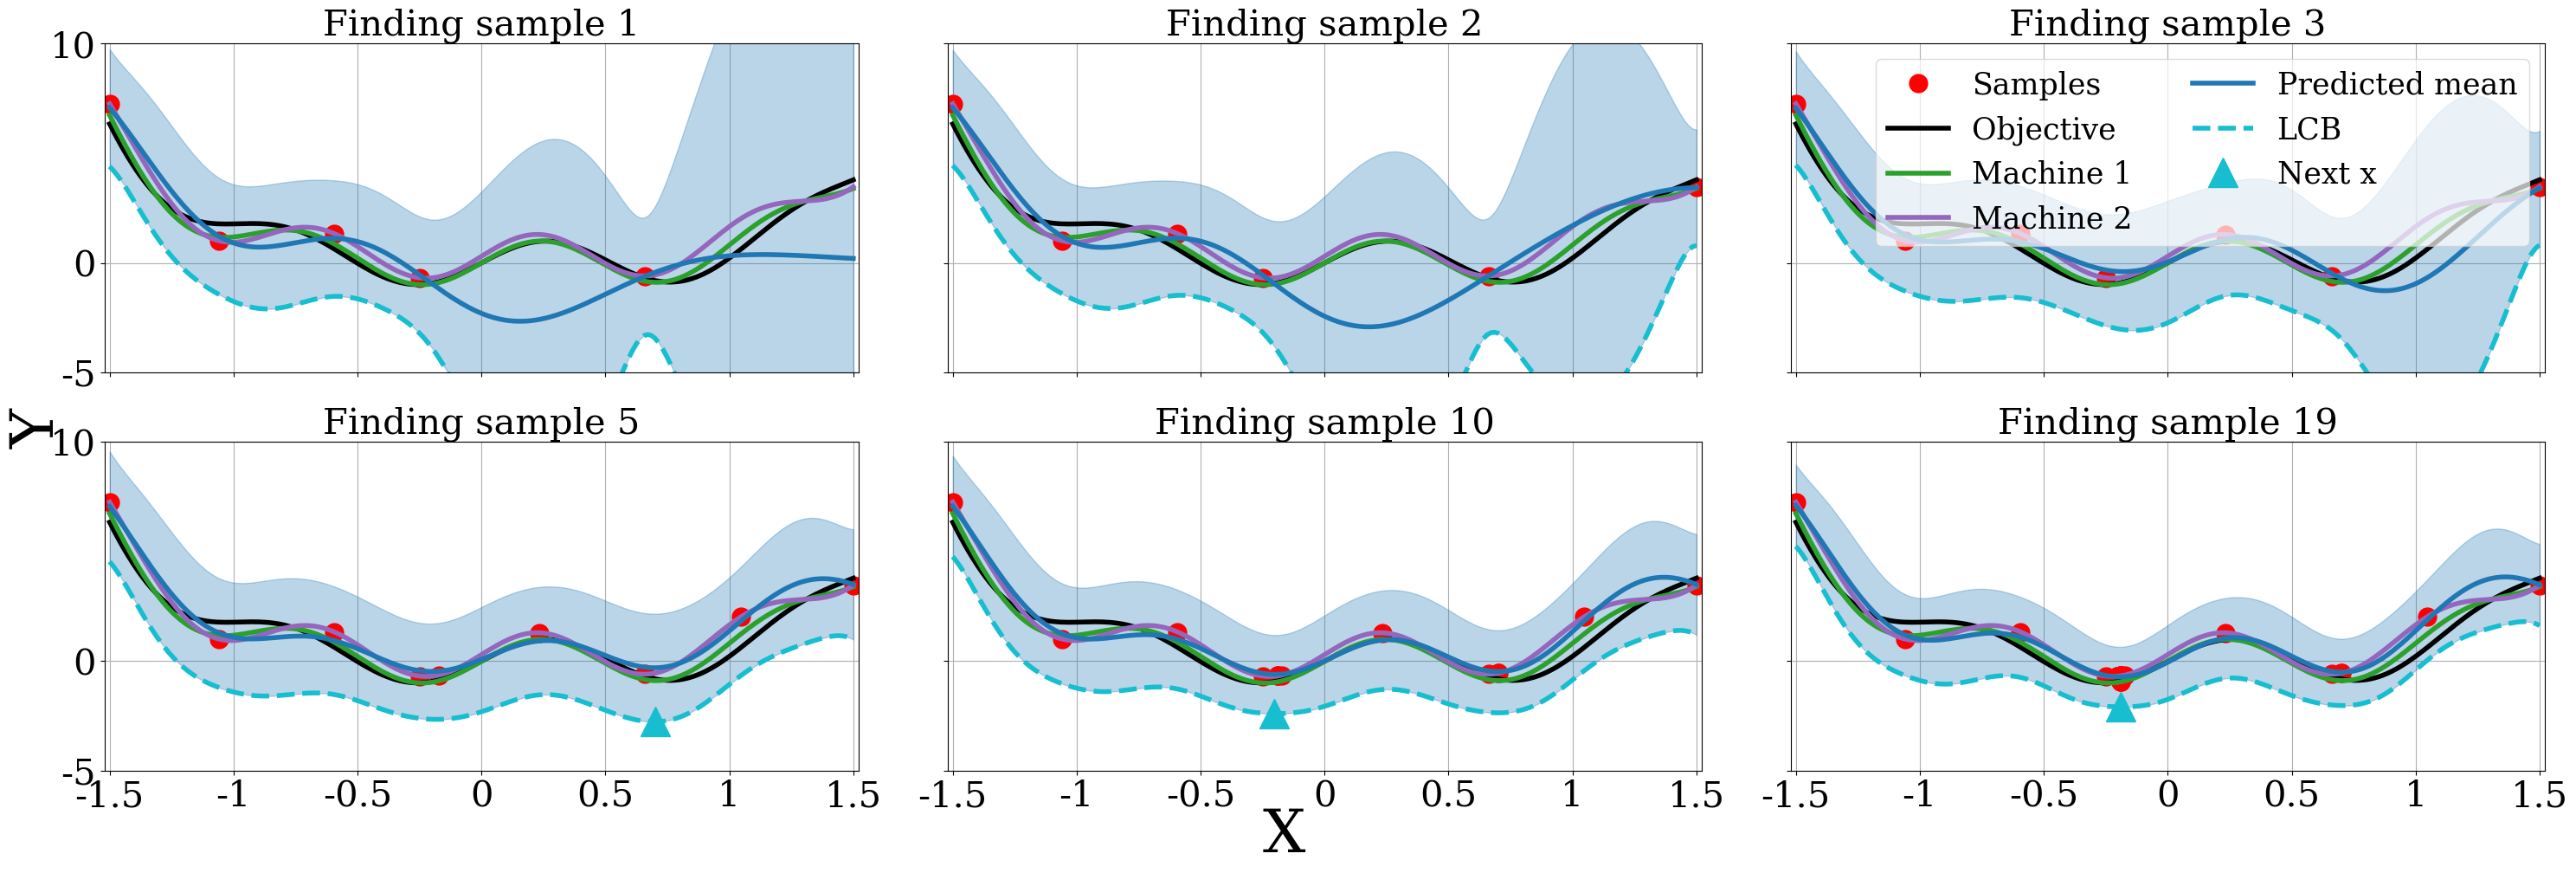

In [107]:
gp.util.train(gpr, optim, loss_fn=loss_fn, num_steps=1) 

fig, axes = plt.subplots(ncols=3, nrows = 2, figsize = (30,10),sharex = True,sharey = True)  # or nrows=3, (30,15)
axs = fig.get_axes()

for i in range(iterations):
    if i >= iterations:
        break
    
    kappa = deter_kappa(ini_kappa, i, dec_param) # Decrease kappa
    next_x, min_val, min_index, distance = opt_acquisition(X_res, kappa, gpr) # Find next x to sample and the minimum value of the acquisition function

    if abs(next_x - old_x) <= margin: # Early stopping 
        early_stop += 1
        if early_stop == 5:
            #print(f"Noise level: {ini_noise}")
            #print(f"Offset level: {ini_offset}")
            print(f"Margin for early stopping: {margin}")
            print(f"Number of iterations to achieve convergence: {i}")
            print(f"Final value of kappa, when convergence was reached: {kappa+dec_param}")
            print(f"Final value of x^* = {next_x.numpy():.2f}")
            with torch.no_grad():
                mu,_ = gpr(X_res, full_cov=False, noiseless=False)
                print(f"Estimated minimum value according to GPR mean: {mu[min_index]}")
            break
    elif next_x != old_x:
        early_stop = 1
    else:
        "Error with early stopping"
    
    # Plotting only certain steps in the optimization
    if i == 0 or i == 1 or i == 2 or i == 4 or i == 34 or i == 9  or i == 18 or i == 24: 
        plot_only_baye(axs[j], gpr, next_x, min_val, X_res, kappa, i)
        j += 1
    new_posterior(next_x, gpr, distance)
    old_x = next_x

fig.text(0.5, 0.03, 'X', ha='center', va='center', fontsize = 50)
fig.text(0.02, 0.5, 'Y', ha='center', va='center', rotation='vertical', fontsize = 50)
axes[0,-1].legend(loc=1, prop={'size': 25}, ncol = 2, framealpha=0.7)
plt.tight_layout(rect=[0.02, 0.04, 1, 1])
#plt.savefig('modality_both_iniM1samp.pdf', format='pdf') 